In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import pydeseq2
import matplotlib.pyplot as plt

import decoupler as dc

## Load data

In [2]:
Smillie_marker      = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/colon_epithelial_marker.csv')
CellCycle_marker    = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/cell_cycle/cell_cycle_marker.tsv', sep='\t')
G2M_markers = list(CellCycle_marker[(CellCycle_marker['phase']=='G2/M')]['gene_symbol'])
S_markers   = list(CellCycle_marker[(CellCycle_marker['phase']=='S')]['gene_symbol'])

In [6]:
adata_joanito = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [7]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_chen.obs['PatientID'] ]

In [8]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

## Regulon-based clustering using pySCENIC

In [13]:
from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/pyscenic/transform.py:42: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  ("Enrichment", COLUMN_NAME_ANNOTATION): np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [14]:
# Specify database:
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
# feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather'
# feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
# feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather'
# Download database with zsync_curl:
"${ZSYNC_CURL}" "${feather_database_url}.zsync"

'1.26.4'

### Subset tumor cells

In [6]:
adata_chen_tumor = adata_chen[(adata_chen.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)) & 
                                      (adata_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_joanito_tumor = adata_joanito[(adata_joanito.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)) & 
                                            (adata_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()

In [9]:
adata_chen_tumor

NameError: name 'adata_chen_tumor' is not defined

In [7]:
adata_chen_tumor = adata_chen_tumor.raw.to_adata()
sc.pp.normalize_total(adata_chen_tumor)
sc.pp.log1p(adata_chen_tumor)

adata_joanito_tumor = adata_joanito_tumor.raw.to_adata()
sc.pp.normalize_total(adata_joanito_tumor)
sc.pp.log1p(adata_joanito_tumor)

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_joanito_tumor.var["mt"] = adata_joanito_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_joanito_tumor.var["ribo"] = adata_joanito_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_joanito_tumor.var["hb"] = adata_joanito_tumor.var_names.str.contains("^HB[^(P)]")

adata_joanito_tumor = adata_joanito_tumor[:, adata_joanito_tumor.var.mt==False].copy()
adata_joanito_tumor = adata_joanito_tumor[:, adata_joanito_tumor.var.ribo==False].copy()
adata_joanito_tumor = adata_joanito_tumor[:, adata_joanito_tumor.var.hb==False].copy()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_chen_tumor.var["mt"] = adata_chen_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_chen_tumor.var["ribo"] = adata_chen_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_chen_tumor.var["hb"] = adata_chen_tumor.var_names.str.contains("^HB[^(P)]")

adata_chen_tumor = adata_chen_tumor[:, adata_chen_tumor.var.mt==False].copy()
adata_chen_tumor = adata_chen_tumor[:, adata_chen_tumor.var.ribo==False].copy()
adata_chen_tumor = adata_chen_tumor[:, adata_chen_tumor.var.hb==False].copy()

<Axes: xlabel='AvgSTRDiff', ylabel='PatientID'>

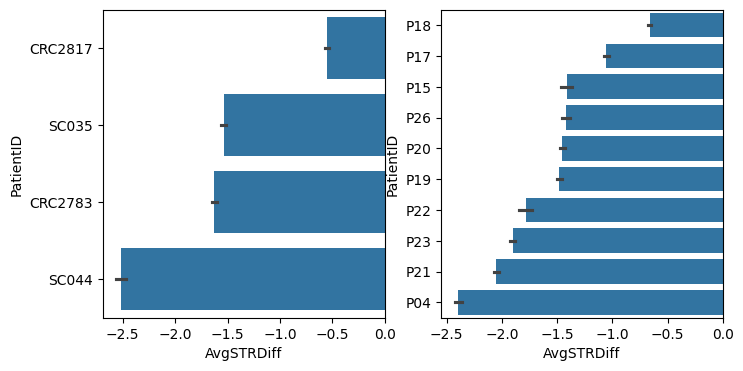

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.barplot(data=adata_joanito_tumor.obs, y='PatientID', x='AvgSTRDiff', order=joanito_patient_order_by_MSI_intensity, ax=axes[0])
sns.barplot(data=adata_chen_tumor.obs, y='PatientID', x='AvgSTRDiff', order=chen_patient_order_by_MSI_intensity, ax=axes[1])

## Assign MSI class: MSI-L vs. MSI-I vs. MSI-H (TBD)

In [ ]:
{'CRC2783': 'MSI-I',
 'CRC2817': 'MSI-L',
 'SC035': 'MSI-I',
 'SC044': 'MSI-H',
 'P04': 'MSI-H',
 'P15': 'MSI-I',
 'P17': 'MSI-L',
 'P18': 'MSI-L',
 'P19': 'MSI-I',
 'P20': 'MSI-I',
 'P21': 'MSI-H',
 'P22': 'MSI-I',
 'P23': 'MSI-H',
 'P26': 'MSI-I'}